## Setup and Import Libraries

In [36]:
import os
import cassio
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableLambda
from langchain.schema import Document
from typing import Annotated, Literal, List
from typing_extensions import TypedDict
from pprint import pprint
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
os.environ["ASTRA_DB_ID"] = os.getenv("ASTRA_DB_ID")

In [5]:
cassio.init(
    token=os.environ["ASTRA_DB_APPLICATION_TOKEN"],
    database_id=os.environ["ASTRA_DB_ID"]
)

In [6]:
llm = ChatGroq(model_name="Gemma2-9b-It")

In [8]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

## Wikipedia Tool

In [9]:
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [10]:
wikipedia_tool.run("Tell me about Lionel Messi")

'Page: Lionel Messi\nSummary: Lionel Andrés "Leo" Messi (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major League Soccer club Inter Miami and the Argentina national team. Widely regarded as one'

## Web Base Loader

In [11]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

In [12]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
texts = text_splitter.split_documents(documents=docs_list)

In [13]:
# docs_list

In [14]:
# texts

## Vector Database

In [15]:
vector_store = Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None
)

In [16]:
vector_store.add_documents(documents=texts)
print(f"Inserted {len(texts)} headlines")

Inserted 88 headlines


In [17]:
vector_index = VectorStoreIndexWrapper(vectorstore=vector_store)

In [18]:
retriever = vector_store.as_retriever()

In [19]:
retriever.invoke("What is Prompt Engineering")

[Document(id='13063e52b689457ab1a453cdead51b84', metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content="Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for des

## Langgraph Application

In [20]:
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource """
    datasource: Literal["vector_store","wiki_search"] = Field(
        ...,
        description="Given a user query choose to route it to wikipedia or a vector_store"
    )

In [21]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [22]:
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router

In [23]:
print(question_router.invoke({"question": "What is Prompt Engineering?"}))

datasource='vector_store'


In [24]:
print(question_router.invoke({"question": "Who is Albert Einstien?"}))

datasource='wiki_search'


## AI Agents

In [25]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question:str
    generation:str
    documents: List[str]

In [26]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("--- Retrieve ---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents, "question":question}

In [27]:
def wiki_search(state):
    """
    Wiki search based on the re-phrased question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Update documents key with append web results
    """

    print("--- Wikipedia ---")
    question = state["question"]

    docs = wikipedia_tool.invoke({"query", question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)
    return {"documents": wiki_results, "question":question}

In [28]:
def route_question(state):
    """
    Route question to wiki search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("--- ROUTE QUESTION ---")
    question = state["question"]

    source = question_router.invoke({"question": question})

    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO WIKI SEARCH---")
        return "wiki_search"
    elif source.datasource == "vector_store":
        print("---ROUTE QUESTION TO VECTOR STORE---")
        return "vector_store"

## Workflow

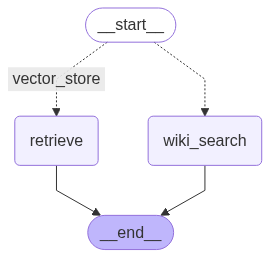

In [37]:
workflow = StateGraph(GraphState)
wiki_search_node = RunnableLambda(lambda x: wikipedia_tool.invoke({"query": x["question"]}))

## Define Nodes
workflow.add_node("wiki_search", wiki_search_node)
workflow.add_node("retrieve", retrieve)

## Build Graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vector_store": "retrieve"
    },
)
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

## Compile
app = workflow.compile()
app

In [38]:
inputs = {
    "question": "What is agent?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")

    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].model_dump()['metadata']['description'])

--- ROUTE QUESTION ---
---ROUTE QUESTION TO VECTOR STORE---
--- Retrieve ---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality

In [44]:
inputs = {
    "question": "Lionel Messi"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")

    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].model_dump()['metadata']['description'])

--- ROUTE QUESTION ---
---ROUTE QUESTION TO WIKI SEARCH---


InvalidUpdateError: Expected dict, got Page: Lionel Messi
Summary: Lionel Andrés "Leo" Messi (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major League Soccer club Inter Miami and the Argentina national team. Widely regarded as one
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE